# Hubble Parameter Constrain
## Alex Pascual

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit
from scipy.stats import norm
from statistics import NormalDist
import plotly.express as px
from scipy.stats import gaussian_kde

In [15]:
# read the data
z, h, herr = np.loadtxt('DataSet/Hz_BC03_all.dat', unpack=True)

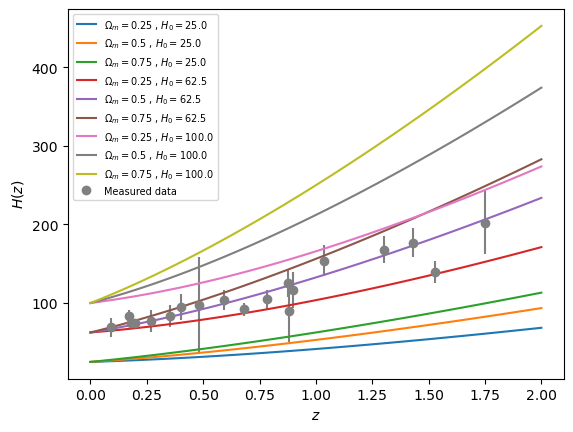

In [3]:
# plot the data
plt.errorbar(z, h, yerr = herr, color = 'grey', fmt = 'o', label = 'Measured data')
x = np.linspace(0, 2, 100)
curves = []
Omegas = np.linspace(0.25, 0.75, 3)
H00 = np.linspace(25, 100, 3)

# sample some curves
def H(aH, H0, Omega):
    k = np.array([])
    for i in range(0, len(aH)):
        k = np.append(k, H0 * np.sqrt(Omega * (1 + aH[i]) ** 3 + (1 - Omega)))
    return k

for l in H00:
    for j in Omegas:
        curves.append(H(x, l, j))
        plt.plot(x, H(x, l, j), label = r'$\Omega_m=${} , $H_0=${}'.format(j,l))

        
plt.xlabel(r'$z$')
plt.ylabel(r'$H(z)$')
plt.legend(loc = 'best', fontsize = 7)
plt.show()

In [4]:
# define a function to calculate H in each point
def Hp(zz, H0, Omega):
    return H0 * np.sqrt(Omega * (1 + zz) ** 3 + (1 - Omega))

# define the posterior likelihood as a multiple variable function (one variable per data)
def Lik(zz, hh, herrr, HH0, OOmega):
    aa = 0
    for i in range(0, len(zz)):
        aa -= (hh[i] - Hp(zz[i], HH0, OOmega)) ** 2 / (herrr[i] ** 2)
    return np.exp(aa / 2.0)

In [5]:
def mcmc(it, step, ostep):
    # (iterations, distance step of H, distance step of Omega)
    # we define a list to store the 3 variables inputted into the function and the new computed
    Likelihoods = np.zeros(it)
    Hs = np.zeros(it)
    Omegas = np.zeros(it)
    
    # We randomly choose initial values to start the computation, following the prior function
    H_old = float(np.random.uniform(50, 100, 1))
    Omega_old = float(np.random.uniform(0, 1, 1)) #this prior may change later
    Lik_old = float(Lik(z, h, herr, H_old, Omega_old))

    # store the values
    Hs[0] = H_old
    Omegas[0] = Omega_old
    Likelihoods[0] = Lik_old
    
    # we'll count the accepted steps to compute the efficiency later
    accepted = 0
    
    for i in range(1, it):
        
        # we choose a step for each variable, following a normal distribution
        dH = np.random.normal(0, step, 1)
        dOmega = np.random.normal(0, ostep, 1)
        
        # we compute the new values of the variables and their posterior (likelihood*prior)
        H_new = H_old + dH
        Omega_new = Omega_old + dOmega
        Lik_new = float(Lik(z, h, herr, H_new, Omega_new) * prior(H_new, Omega_new))
        
        # now, the metropolis algorithm to accept or reject
        # if the new posterior is greater than in the previous step, we accept the change
        if i > 0 and Lik_new >= Lik_old:
            Hs[i] = H_new
            Omegas[i] = Omega_new
            Likelihoods[i] = Lik_new
            accepted += 1
            #make the old variables the new ones to use them in the loop
            H_old = H_new
            Omega_old = Omega_new
            Lik_old = Lik_new
  
        # if the new posterior is smaller, the we throw a die
        elif i > 0 and Lik_new < Lik_old:
            # we choose a random value between 0 and 1
            f = np.random.random(1)
            # if it lands further than the ratio post_new/post_old, we reject the change 
            if f >= Lik_new / Lik_old:
                Hs[i] = Hs[i - 1]
                Omegas[i] = Omegas[i - 1]
                Likelihoods[i] = Likelihoods[i - 1]

            # if it lands otherwise, we accept it
            if f < Lik_new / Lik_old:
                Hs[i] = H_new
                Omegas[i] = Omega_new
                Likelihoods[i] = Lik_new
                accepted += 1
                H_old = H_new
                Omega_old = Omega_new
                Lik_old = Lik_new
        else:
            Hs[i] = Hs[i - 1]
            Omegas[i] = Omegas[i - 1]
            Likelihoods[i] = Likelihoods[i - 1]
                
    return [Hs, Omegas, Likelihoods, accepted / (it - 1)]

In [6]:
# now, the prior
def prior(hh,OOmega):
    if 50 < hh < 100 and 0 < OOmega < 1:
        return 1.0
    else:
        return 0.0

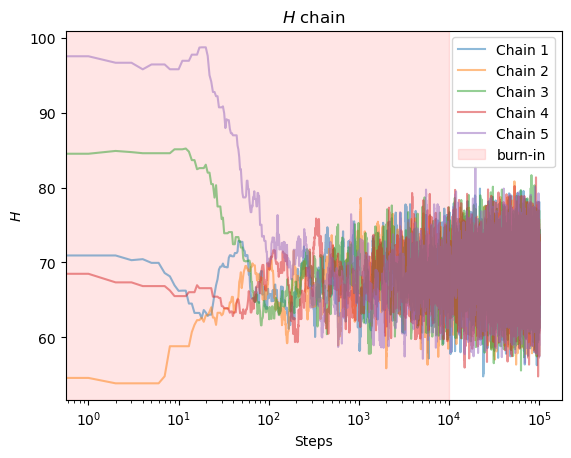

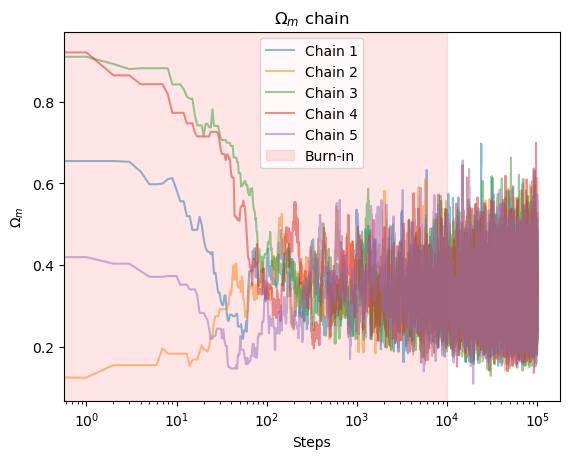

In [7]:
# we run the mcmc 
iterations = 10 ** 5
pos = np.linspace(0, iterations, iterations)
chains = 5
pOmega = []
pH = []
LIKE = []
Efficiency = []

# plot the Hs
for kk in range(0, chains):
    simulation = mcmc(iterations, 1, 0.025)
    pH.append(simulation[0])
    pOmega.append(simulation[1])
    LIKE.append(simulation[2])
    Efficiency.append(simulation[3])

    plt.plot(pos, pH[kk], label = 'Chain {}'.format(kk + 1), alpha = 0.5)
    plt.ylabel(r'$H$')
    plt.xlabel(r'Steps')
    plt.xscale('log')
    plt.title('$H$ chain')

plt.axvspan(0, 10 ** 4, color = 'red', alpha = 0.1, label = 'burn-in')
plt.legend(loc = 'best')
plt.show()

# plot the Omegaas
for kk in range(0, chains):
    plt.plot(pos, pOmega[kk], label = 'Chain {}'.format(kk + 1), alpha = 0.5)
    plt.ylabel(r'$\Omega_m$')
    plt.xlabel(r'Steps')
    plt.xscale('log')
    plt.title('$\Omega_m$ chain')

plt.axvspan(0, 10 ** 4, color = 'red', alpha = 0.1, label = 'Burn-in')
plt.legend(loc = 'best')
plt.show()

In [8]:
# print efficiency
print('Efficiency = {}'.format(np.mean(Efficiency)))

# print(pH)
# define a function that calculates the convergence metric for a given chain
def R(CHAIN, nchains):
    N = len(CHAIN[0])
    B = 0
    W = 0
    yCHAIN = []
    for kk in range(0, nchains):
        yCHAIN.append(np.mean(CHAIN[kk]))
    ybarCHAIN=float(np.mean(yCHAIN))
    summ = 0
    for i in range(0, nchains):
        summ += (yCHAIN[i] - ybarCHAIN) ** 2
    B = 1 / (nchains-1) * summ
    summ2 = 0
    for i in range(0, N):
        for j in range(0, nchains):
            summ2 += (CHAIN[j][i] - yCHAIN[j]) ** 2
    W = 1 / (nchains*(N - 1)) * summ2
    return ( (N - 1) / N * W + B * (1 + 1 / nchains)) / W

print('R of H =  {}\nR of Omega = {}'.format(R(pH, chains), R(pOmega, chains)))

Efficiency = 0.7026910269102691
R of H =  1.0004282207722655
R of Omega = 1.0003746433915244


In [10]:
# arange all the chains in one
X = np.array([])
Y = np.array([])
for nn in range(0, chains):
    # we plot the 20% of the total points to optimize the execution
    X = np.concatenate((X, pH[nn][int(7 * 10 ** 4):]), axis = 0)
    Y = np.concatenate((Y, pOmega[nn][int(7 * 10 ** 4):]), axis = 0)


Text(0, 0.5, '$H$')

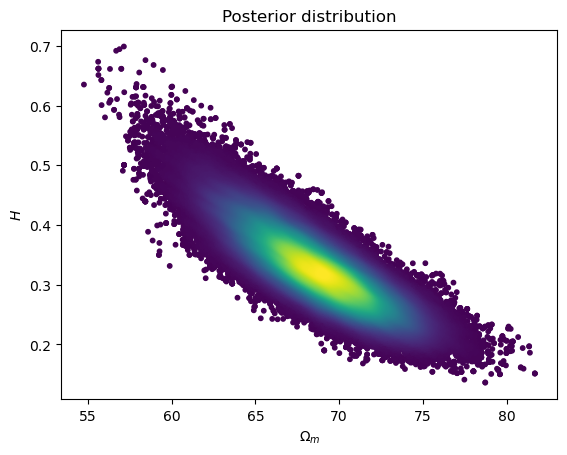

In [11]:
xy = np.vstack([X, Y])

# sort by color/density
Z = gaussian_kde(xy)(xy)
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]
fig, ax = plt.subplots()
Real = ax.scatter(X, Y, c = Z, s = 10)

# plot
plt.title('Posterior distribution')
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$H$')
plt.show()

71.23% confidence interval of H = [65.93267799622467, 71.85294592784953]
70.54% confidence interval of Omega = [0.2628476940443477, 0.36980541657978727]
H mode = 68.89281196203709
Omega mode = 0.31632655531206744


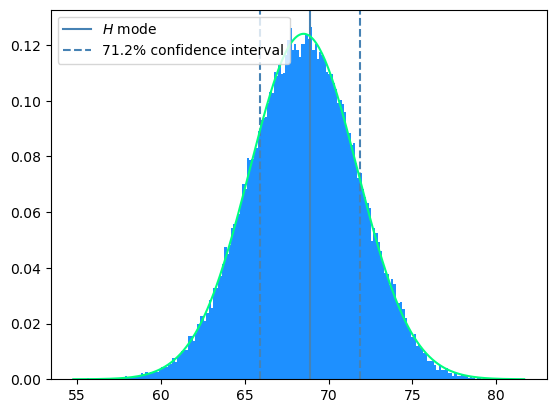

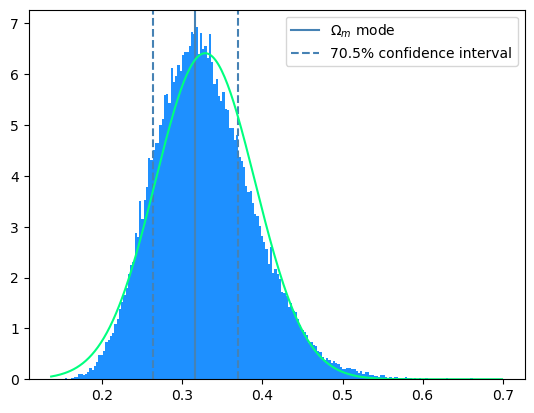

In [12]:
# define the function that calulates the 68% confidence interval
def conf(hist):
    #calculate the total area
    area = np.sum(hist[0])
    modeindex = int(np.argmax(hist[0]))
    mode = hist[1][modeindex]
    summ = float(hist[0][modeindex])
    i = 1
    for k in range(0,len(hist[0])):
        summ += float(hist[0][modeindex + 1])
        if summ / area < 0.68:
            summ += float(hist[0][modeindex - 1])
            i += 1
        else:
            break
    return [hist[1][modeindex - i], hist[1][modeindex + i],summ / area]


def gauss(chain,hist):
    xx = np.linspace(np.min(chain), np.max(chain), 300)
    std = np.std(chain)
    mean = np.mean(chain)
    gau = []
    for k in range(0, len(xx)):
        gau.append(1 / np.sqrt(2 * std ** 2 * np.pi) * np.exp(-(xx[k]-mean) ** 2 / (2 * std ** 2)))
    return [xx, gau]
    
        
bins = 200
# plot the histograms separately
histH = np.histogram(X, bins = bins)
mH=histH[1][np.argmax(histH[0])]
print('{:.4}% confidence interval of H = {}'.format(100 * conf(histH)[2], conf(histH)[0:2]))



histO = np.histogram(Y, bins = bins)
mO = histO[1][np.argmax(histO[0])]
print('{:.4}% confidence interval of Omega = {}'.format(100 * conf(histO)[2], conf(histO)[0:2]))
print('H mode = {}\nOmega mode = {}'.format(mH, mO))
lowX = []
highX = []
lowY = []
highY = []
for k in range(0, len(X)):
    if X[k] < conf(histH)[0] or X[k] > conf(histH)[1]:
        lowX.append(X[k])
    else:
        highX.append(X[k])
for k in range(0, len(Y)):
    if Y[k] < conf(histO)[0] or Y[k] > conf(histO)[1]:
        lowY.append(Y[k])
    else:
        highY.append(Y[k])


histH = plt.hist(X ,bins=int(bins), color = 'dodgerblue', density = True)
plt.axvline(mH, label = '$H$ mode', color = 'steelblue')
plt.axvline(conf(histH)[1], label = '{:.3}% confidence interval'.format(100 * conf(histH)[2]), color = 'steelblue', linestyle = '--')
plt.axvline(conf(histH)[0], color = 'steelblue', linestyle = '--')
plt.plot(gauss(X, histH)[0], gauss(X,histH)[1], color = 'springgreen')
plt.legend(loc = 'best')
plt.show()

histO = plt.hist(Y, bins = int(bins), color = 'dodgerblue', density = True)
plt.axvline(mO, label = '$\Omega_m$ mode', color = 'steelblue')
plt.axvline(conf(histO)[1], label = '{:.3}% confidence interval'.format(100 * conf(histO)[2]), color = 'steelblue', linestyle = '--')
plt.axvline(conf(histO)[0], color = 'steelblue', linestyle = '--')
plt.plot(gauss(Y ,histO)[0], gauss(Y,histO)[1], color = 'springgreen')
plt.legend(loc = 'best')
plt.show()

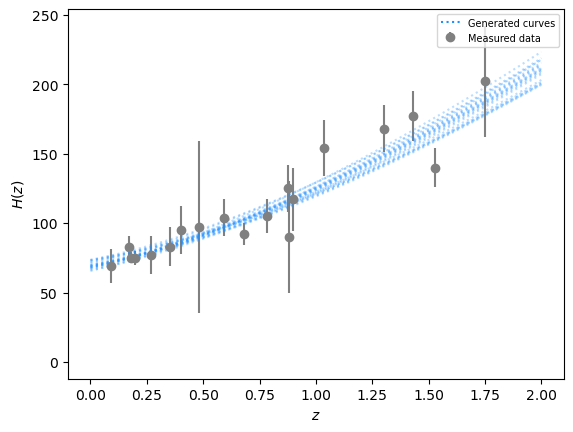

In [16]:
# plot the data
plt.errorbar(z, h, yerr = herr, color = 'grey', fmt = 'o', label = 'Measured data')
x = np.linspace(0, 2, 100)
curves = []
Omegas = []
H00 = []
al = []
n = 20
for k in range(0, n):
    al.append(np.random.randint(0, len(X)))
for k in range(0, len(al)):
    Omegas.append(Y[al[k]])
    H00.append(X[al[k]])



# sample some curves
def H(aH,H0,Omega):
    k = np.array([])
    for i in range(0, len(aH)):
        k = np.append(k, H0 * np.sqrt(Omega * (1 + aH[i]) ** 3 + (1 - Omega)))
    return k


for j in range(0, n):
    curves.append(H(x, H00[j], Omegas[j]))
    plt.plot(x, H(x, H00[j], Omegas[j]), color = 'dodgerblue', linestyle = ':', alpha = 0.3)
plt.plot([0], [0], color = 'dodgerblue', linestyle = ':', label = 'Generated curves')
        
plt.xlabel(r'$z$')
plt.ylabel(r'$H(z)$')
plt.legend(loc = 'best', fontsize = 7)
plt.show()

In [17]:
# new prior
def prior2(hh, OOmega):
    m = 0.315
    std = 0.007
    if 50 < hh < 100:
        return 1 / np.sqrt(2 * std ** 2 * np.pi) * np.exp(-(OOmega - m) ** 2 / (2 * std ** 2))
    else:
        return 0.0
    

In [18]:
#ALMOST THE SAME FUNCTION, WITH DIFFERENT PRIORS
def mcmc(it, step, ostep):
    # we define a list to store the 3 variables inputted into the function and the new computed
    Likelihoods = np.zeros(it)
    Hs = np.zeros(it)
    Omegas = np.zeros(it)
    
    # We randomly choose initial values to start the computation
    H_old= float(np.random.uniform(50, 100, 1))
    Omega_old = float(np.random.normal(0.315, 0.007))
    Lik_old = float(Lik(z, h, herr, H_old, Omega_old))

    # store the values
    Hs[0] = H_old
    Omegas[0] = Omega_old
    Likelihoods[0] = Lik_old
    accepted = 0

    for i in range(1,it):
        
        # we choose a step for each variable, following a normal distribution
        dH = np.random.normal(0, step, 1)
        dOmega = np.random.normal(0, ostep, 1)
        
        # we compute the new values of the variables and their posterior (likelihood*prior2)
        H_new = H_old + dH
        Omega_new = Omega_old + dOmega
        Lik_new = float(Lik(z, h, herr, H_new, Omega_new) * prior2(H_new, Omega_new))
        
        # now, the metropolis algorithm to accept or reject
        
        
        # if the new posterior is greater than in the previous step, we accept the change
        if i > 0 and Lik_new >= Lik_old:
            Hs[i] = H_new
            Omegas[i] = Omega_new
            Likelihoods[i] = Lik_new
            accepted += 1
            H_old = H_new
            Omega_old = Omega_new
            Lik_old = Lik_new
  
        # if the new posterior is smaller, the we throw a die
        elif i > 0 and Lik_new < Lik_old:
            #w e choose a random value betwwen 0 and 1
            f = np.random.random(1)
            # if it lands further than the ratio post_new/post_old, we reject the change 
            if f >= Lik_new / Lik_old:
                Hs[i] = Hs[i - 1]
                Omegas[i] = Omegas[i - 1]
                Likelihoods[i] = Likelihoods[i - 1]

            # if it lands otherwise, we accept it
            if f < Lik_new / Lik_old:
                Hs[i] = H_new
                Omegas[i] = Omega_new
                Likelihoods[i] = Lik_new
                accepted += 1
                H_old = H_new
                Omega_old = Omega_new
                Lik_old = Lik_new
        else:
            Hs[i] = Hs[i - 1]
            Omegas[i] = Omegas[i - 1]
            Likelihoods[i] = Likelihoods[i - 1]
                
    return [Hs, Omegas, Likelihoods, accepted / (it - 1)]

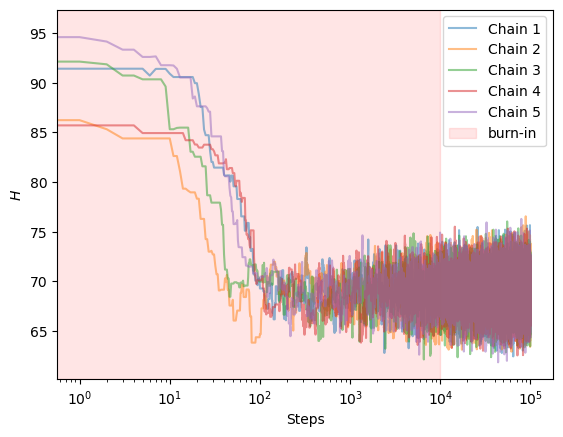

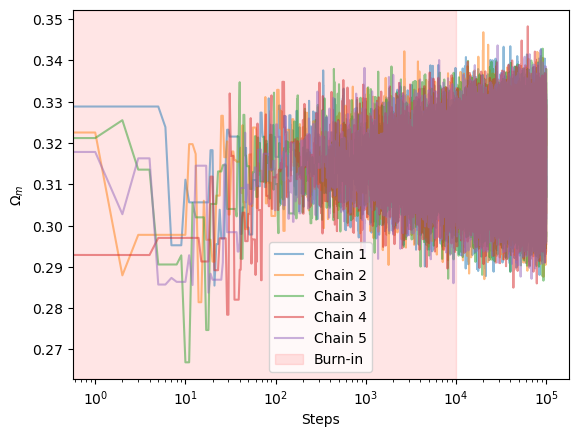

In [20]:
# we run the mcmc 
iterations = 10 ** 5
pos = np.linspace(0, iterations, iterations)
chains = 5
pOmega = []
pH = []
LIKE = []
Efficiency = []
# plot the Hs
for kk in range(0, chains):
    simulation = mcmc(iterations, 1, 0.025)
    pH.append(simulation[0])
    pOmega.append(simulation[1])
    LIKE.append(simulation[2])
    Efficiency.append(simulation[3])

    plt.plot(pos, pH[kk], label = 'Chain {}'.format(kk + 1), alpha = 0.5)
    plt.ylabel(r'$H$')
    plt.xlabel(r'Steps')
    plt.xscale('log')
plt.axvspan(0, 10 ** 4, color = 'red', alpha = 0.1, label = 'burn-in')
plt.legend(loc = 'best')
plt.show()

# plot the Omegaas
for kk in range(0, chains):
    plt.plot(pos, pOmega[kk], label = 'Chain {}'.format(kk + 1), alpha = 0.5)
    plt.ylabel(r'$\Omega_m$')
    plt.xlabel(r'Steps')
    plt.xscale('log')
plt.axvspan(0, 10 ** 4, color = 'red', alpha = 0.1, label = 'Burn-in')
plt.legend(loc = 'best')
plt.show()

In [21]:
# print efficiency
print('Efficiency = {}'.format(np.mean(Efficiency)))

# print(pH)
# define a function that calculates the convergence metric for a given chain
def R(CHAIN, nchains):
    N = len(CHAIN[0])
    B = 0
    W = 0
    yCHAIN = []
    for kk in range(0, nchains):
        yCHAIN.append(np.mean(CHAIN[kk]))
    ybarCHAIN=float(np.mean(yCHAIN))
    summ = 0
    for i in range(0, nchains):
        summ += (yCHAIN[i] - ybarCHAIN) ** 2
    B = 1 / (nchains-1) * summ
    summ2 = 0
    for i in range(0, N):
        for j in range(0, nchains):
            summ2 += (CHAIN[j][i] - yCHAIN[j]) ** 2
    W = 1 / (nchains*(N - 1)) * summ2
    return ( (N - 1) / N * W + B * (1 + 1 / nchains)) / W

print('R of H =  {}\nR of Omega = {}'.format(R(pH, chains), R(pOmega, chains)))

Efficiency = 0.29175691756917566
R of H =  1.0004895176043775
R of Omega = 1.0000821308361982


In [24]:
# arange all the chains in one
X = np.array([])
Y = np.array([])
for nn in range(0, chains):
    #we plot the 20% of the total points to optimize the execution
    X = np.concatenate((X, pH[nn][int(7 * 10 ** 4):]), axis = 0)
    Y = np.concatenate((Y, pOmega[nn][int(7 * 10 ** 4):]), axis = 0)


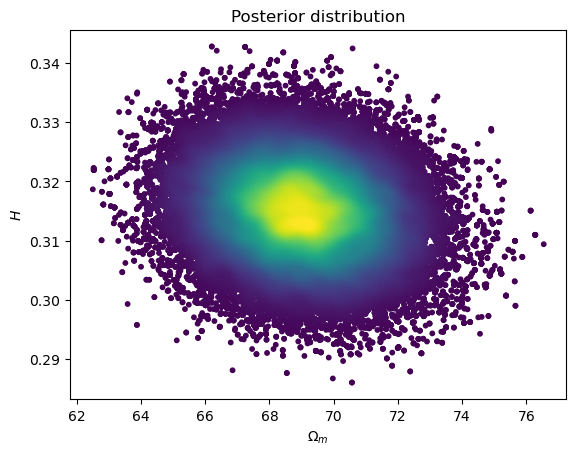

In [26]:
xy = np.vstack([X, Y])

# sort by color/density
Z = gaussian_kde(xy)(xy)
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]
fig, ax = plt.subplots()
Real = ax.scatter(X, Y, c = Z, s = 10)
# plot
plt.title('Posterior distribution')
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$H$')
plt.show()

71.92% confidence interval of H = [66.85246390118868, 70.22154526098069]
69.5% confidence interval of Omega = [0.30815367344070066, 0.3206573511451512]
H mode = 68.53700458108469
Omega mode = 0.3144055122929259


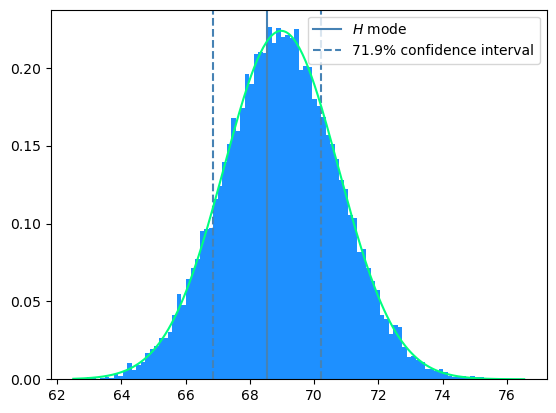

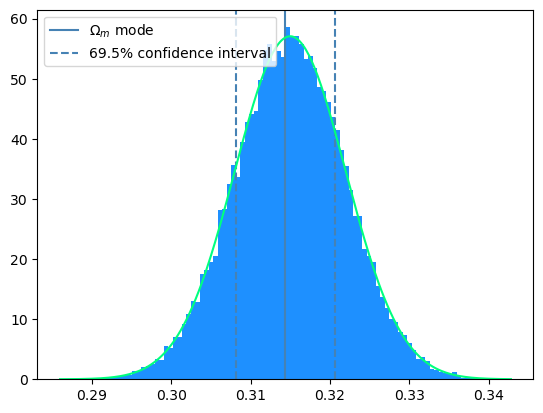

In [27]:
# define the function that calulates the 68% confidence interval
def conf(hist):
    #calculate the total area
    area = np.sum(hist[0])
    modeindex = int(np.argmax(hist[0]))
    mode = hist[1][modeindex]
    summ = float(hist[0][modeindex])
    i = 1
    for k in range(0, len(hist[0])):
        summ += float(hist[0][modeindex + 1])
        if summ / area < 0.68:
            summ += float(hist[0][modeindex - 1])
            i += 1
        else:
            break
    return [hist[1][modeindex - i], hist[1][modeindex + i], summ / area]

def gauss(chain, hist):
    xx = np.linspace(np.min(chain), np.max(chain), 300)
    std = np.std(chain)
    mean = np.mean(chain)
    gau = []
    for k in range(0, len(xx)):
        gau.append(1 / np.sqrt(2 * std ** 2 * np.pi) * np.exp(-(xx[k] - mean) ** 2 / (2 * std ** 2)))
    return [xx, gau]
    
        
bins = 100
# plot the histograms separately
histH = np.histogram(X, bins = bins)
mH = histH[1][np.argmax(histH[0])]
print('{:.4}% confidence interval of H = {}'.format(100 * conf(histH)[2], conf(histH)[0:2]))



histO = np.histogram(Y, bins = bins)
mO = histO[1][np.argmax(histO[0])]
print('{:.4}% confidence interval of Omega = {}'.format(100 * conf(histO)[2], conf(histO)[0:2]))
print('H mode = {}\nOmega mode = {}'.format(mH, mO))
lowX = []
highX = []
lowY = []
highY = []
for k in range(0, len(X)):
    if X[k] < conf(histH)[0] or X[k] > conf(histH)[1]:
        lowX.append(X[k])
    else:
        highX.append(X[k])
for k in range(0, len(Y)):
    if Y[k] < conf(histO)[0] or Y[k] > conf(histO)[1]:
        lowY.append(Y[k])
    else:
        highY.append(Y[k])

histH = plt.hist(X, bins = int(bins), color = 'dodgerblue', density = True)
plt.axvline(mH, label = '$H$ mode', color = 'steelblue')
plt.axvline(conf(histH)[1], label = '{:.3}% confidence interval'.format(100 * conf(histH)[2]), color = 'steelblue', linestyle = '--')
plt.axvline(conf(histH)[0],color = 'steelblue', linestyle = '--')
plt.plot(gauss(X, histH)[0],gauss(X, histH)[1], color = 'springgreen')
plt.legend(loc = 'best')
plt.show()

histO = plt.hist(Y, bins = int(bins), color = 'dodgerblue', density = True)
plt.axvline(mO, label = '$\Omega_m$ mode', color = 'steelblue')
plt.axvline(conf(histO)[1], label = '{:.3}% confidence interval'.format(100 * conf(histO)[2]), color = 'steelblue', linestyle = '--')
plt.axvline(conf(histO)[0], color = 'steelblue', linestyle = '--')
plt.plot(gauss(Y, histO)[0], gauss(Y, histO)[1], color = 'springgreen')
plt.legend(loc = 'best')
plt.show()

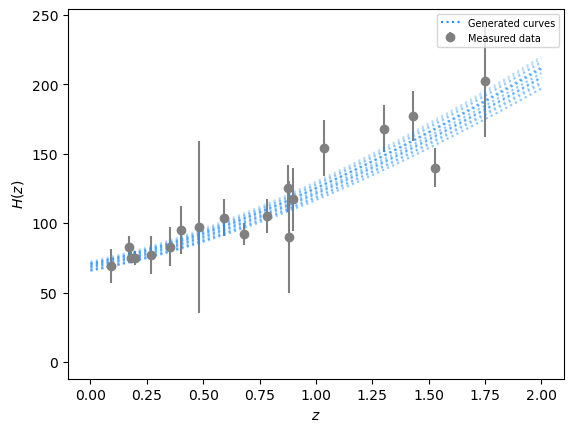

In [28]:
# plot the data
plt.errorbar(z, h, yerr = herr, color = 'grey', fmt = 'o', label = 'Measured data')
x = np.linspace(0, 2, 100)
curves = []
Omegas = []
H00 = []
al = []
n = 20
for k in range(0, n):
    al.append(np.random.randint(0, len(X)))
for k in range(0, len(al)):
    Omegas.append(Y[al[k]])
    H00.append(X[al[k]])



# sample some curves
def H(aH,H0,Omega):
    k = np.array([])
    for i in range(0, len(aH)):
        k = np.append(k, H0 * np.sqrt(Omega * (1 + aH[i]) ** 3 + (1 - Omega)))
    return k


for j in range(0, n):
    curves.append(H(x, H00[j], Omegas[j]))
    plt.plot(x, H(x, H00[j], Omegas[j]), color = 'dodgerblue', linestyle = ':', alpha = 0.3)
plt.plot([0], [0], color = 'dodgerblue', linestyle = ':', label = 'Generated curves')
        
plt.xlabel(r'$z$')
plt.ylabel(r'$H(z)$')
plt.legend(loc = 'best', fontsize = 7)
plt.show()